## MSBD566 - MidTerm Assignment 3
## Esmeralda Garcia
Data Source: https://www.kaggle.com/datasets/samiraalipour/genomics-of-drug-sensitivity-in-cancer-gdsc?resource=download&select=GDSC_DATASET.csv

In [4]:
# modules needed for assignment
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc
)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
plt.rcParams["figure.dpi"] = 120

In [5]:
df = pd.read_csv("GDSC_DATASET.csv")

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242035 entries, 0 to 242034
Data columns (total 19 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   COSMIC_ID                                242035 non-null  int64  
 1   CELL_LINE_NAME                           242035 non-null  object 
 2   TCGA_DESC                                240968 non-null  object 
 3   DRUG_ID                                  242035 non-null  int64  
 4   DRUG_NAME                                242035 non-null  object 
 5   LN_IC50                                  242035 non-null  float64
 6   AUC                                      242035 non-null  float64
 7   Z_SCORE                                  242035 non-null  float64
 8   GDSC Tissue descriptor 1                 232669 non-null  object 
 9   GDSC Tissue descriptor 2                 232669 non-null  object 
 10  Cancer Type (matching TCGA label

,COSMIC_ID,CELL_LINE_NAME,TCGA_DESC,DRUG_ID,DRUG_NAME,LN_IC50,AUC,Z_SCORE,GDSC Tissue descriptor 1,GDSC Tissue descriptor 2,Cancer Type (matching TCGA label),Microsatellite instability Status (MSI),Screen Medium,Growth Properties,CNA,Gene Expression,Methylation,TARGET,TARGET_PATHWAY
0,683667,PFSK-1,MB,1003,Camptothecin,-1.463887,0.930220,0.433123,nervous_system,medulloblastoma,MB,MSS/MSI-L,R,Adherent,Y,Y,Y,TOP1,DNA replication
1,684057,ES5,UNCLASSIFIED,1003,Camptothecin,-3.360586,0.791072,-0.599569,bone,ewings_sarcoma,NaN,MSS/MSI-L,R,Adherent,Y,Y,Y,TOP1,DNA replication
2,684059,ES7,UNCLASSIFIED,1003,Camptothecin,-5.044940,0.592660,-1.516647,bone,ewings_sarcoma,NaN,MSS/MSI-L,R,Adherent,Y,Y,Y,TOP1,DNA replication
3,684062,EW-11,UNCLASSIFIED,1003,Camptothecin,-3.741991,0.734047,-0.807232,bone,ewings_sarcoma,NaN,MSS/MSI-L,R,Adherent,Y,Y,Y,TOP1,DNA replication
4,684072,SK-ES-1,UNCLASSIFIED,1003,Camptothecin,-5.142961,0.582439,-1.570016,bone,ewings_sarcoma,NaN,MSS/MSI-L,R,Semi-Adherent,Y,Y,Y,TOP1,DNA replication


Target variable distribution (counts):
TargetClass
Resistant              157188
Average sensitivity     51171
Very potent             33676
Name: count, dtype: int64

Target variable distribution (%):
TargetClass
Resistant              64.94
Average sensitivity    21.14
Very potent            13.91
Name: proportion, dtype: float64


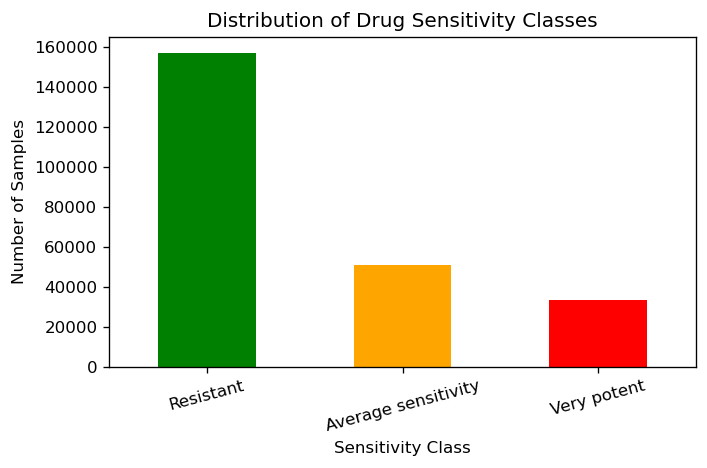

In [8]:
df = pd.read_csv("GDSC_DATASET.csv").copy()

# Target from LN_IC50 (biological cutoffs)
LOW, HIGH = 0.0, np.log(10.0)

def label_ic50(x):
    if x < LOW:        return "Very potent"
    elif x <= HIGH:    return "Average sensitivity"
    else:              return "Resistant"

df = df.dropna(subset=["LN_IC50"]).copy()
df["TargetClass"] = df["LN_IC50"].apply(label_ic50)

# Visual
print("Target variable distribution (counts):")
print(df["TargetClass"].value_counts())
print("\nTarget variable distribution (%):")
print((df["TargetClass"].value_counts(normalize=True) * 100).round(2))
df["TargetClass"].value_counts()

plt.figure(figsize=(6,4))
df["TargetClass"].value_counts().plot(kind="bar", color=["green","orange","red"])
plt.title("Distribution of Drug Sensitivity Classes")
plt.ylabel("Number of Samples")
plt.xlabel("Sensitivity Class")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

Missing values (%):
 Cancer Type (matching TCGA label)          0.212556
TARGET                                     0.112195
Microsatellite instability Status (MSI)    0.051038
Screen Medium                              0.038697
Methylation                                0.038697
Gene Expression                            0.038697
CNA                                        0.038697
GDSC Tissue descriptor 1                   0.038697
GDSC Tissue descriptor 2                   0.038697
Growth Properties                          0.038697
TCGA_DESC                                  0.004408
TARGET_PATHWAY                             0.000000
COSMIC_ID                                  0.000000
CELL_LINE_NAME                             0.000000
Z_SCORE                                    0.000000
dtype: float64


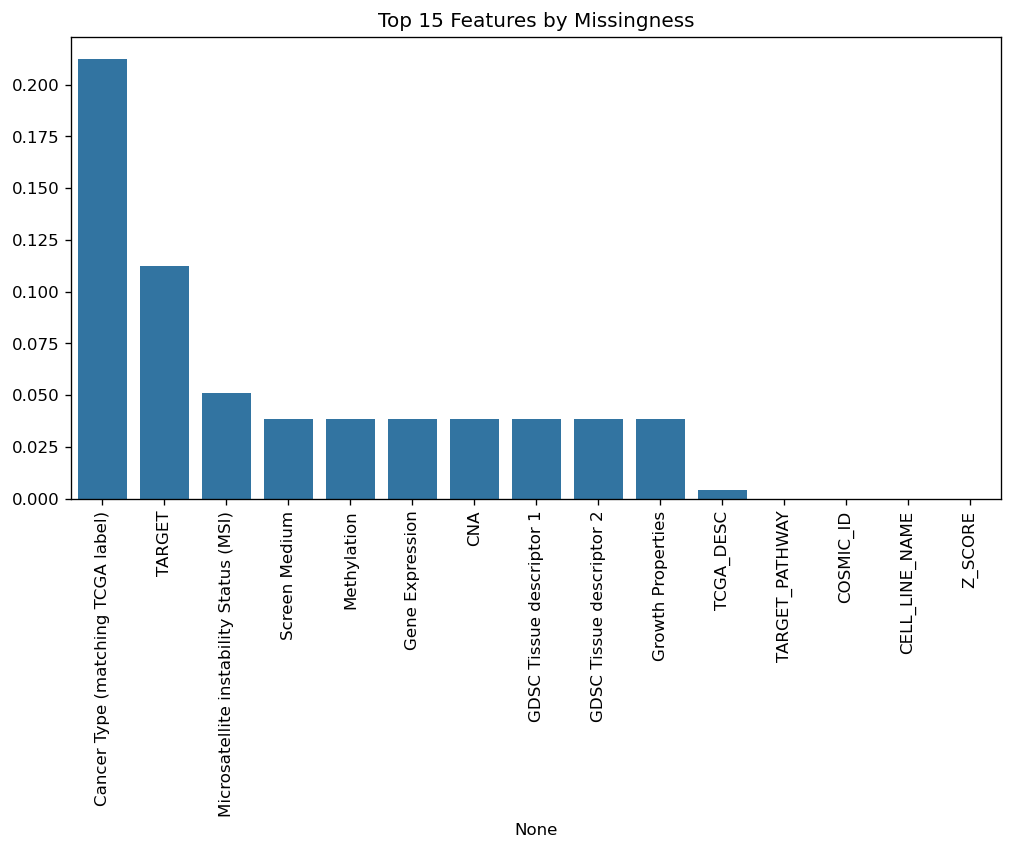

In [9]:
#Find all the missing data in the GDSC_DATASET file
missing = df.isna().mean().sort_values(ascending=False)
print("Missing values (%):\n", missing.head(15))

plt.figure(figsize=(10,5))
sns.barplot(x=missing.index[:15], y=missing.values[:15])
plt.xticks(rotation=90)
plt.title("Top 15 Features by Missingness")
plt.show()

Train class counts:
 TargetClass
Resistant              119103
Average sensitivity     39010
Very potent             25632
Name: count, dtype: int64 

Test class counts:
 TargetClass
Resistant              29776
Average sensitivity     9753
Very potent             6408
Name: count, dtype: int64


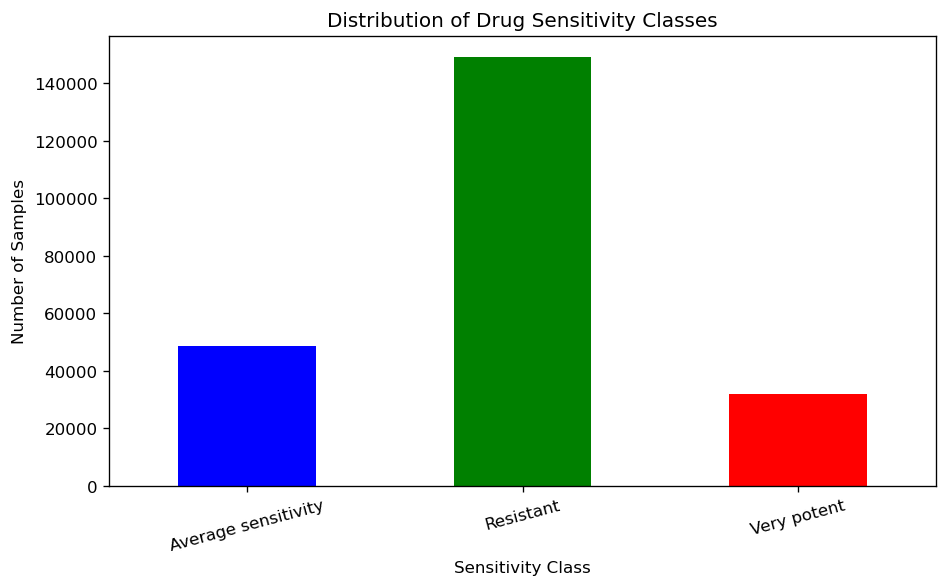

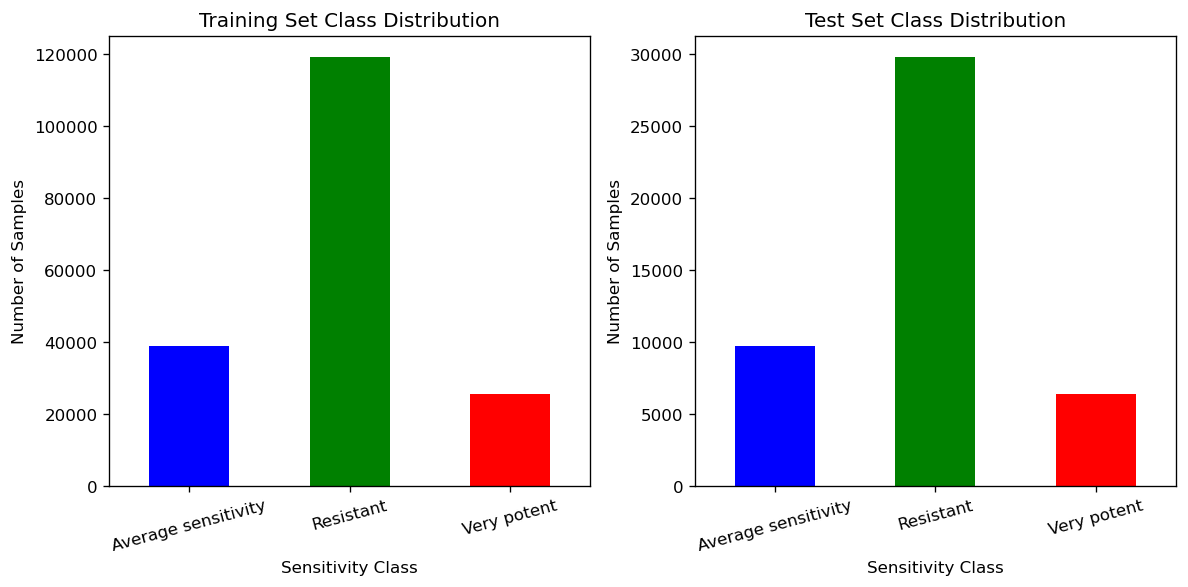

In [15]:
num_feats = [c for c in ["AUC","Z_SCORE","CNA","Gene Expression","Methylation"] if c in df.columns]
cat_feats = [c for c in ["GDSC Tissue descriptor 1","TARGET_PATHWAY",
                         "Microsatellite instability Status (MSI)",
                         "Screen Medium","Growth Properties"] if c in df.columns]

X = df[num_feats + cat_feats].copy()
y = df["TargetClass"].copy()

# drop rows with missing values in any feature
Xy = pd.concat([X, y], axis=1).dropna()
X = Xy.drop(columns=["TargetClass"])
y = Xy["TargetClass"]

# Train/test split
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train class counts:\n", y_tr.value_counts(), "\n")
print("Test class counts:\n", y_te.value_counts())


plt.figure(figsize=(8, 5))
y.value_counts().sort_index().plot(kind="bar", color=colors)
plt.title("Distribution of Drug Sensitivity Classes")
plt.ylabel("Number of Samples")
plt.xlabel("Sensitivity Class")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# Second plot: Train and test distributions
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
y_tr.value_counts().sort_index().plot(kind="bar", color=colors)
plt.title("Training Set Class Distribution")
plt.ylabel("Number of Samples")
plt.xlabel("Sensitivity Class")
plt.xticks(rotation=15)

plt.subplot(1, 2, 2)
y_te.value_counts().sort_index().plot(kind="bar", color=colors)
plt.title("Test Set Class Distribution")
plt.ylabel("Number of Samples")
plt.xlabel("Sensitivity Class")
plt.xticks(rotation=15)

plt.tight_layout()
plt.show()

Number of unique values per column:
LN_IC50                                    237096
Z_SCORE                                    233613
AUC                                        142587
COSMIC_ID                                     969
CELL_LINE_NAME                                969
DRUG_ID                                       295
DRUG_NAME                                     286
TARGET                                        185
GDSC Tissue descriptor 2                       54
TCGA_DESC                                      32
Cancer Type (matching TCGA label)              31
TARGET_PATHWAY                                 24
GDSC Tissue descriptor 1                       19
Growth Properties                               3
TargetClass                                     3
Microsatellite instability Status (MSI)         2
Screen Medium                                   2
CNA                                             2
Gene Expression                                 2
Methylation   

<Axes: title={'center': 'Unique Values per Column'}>

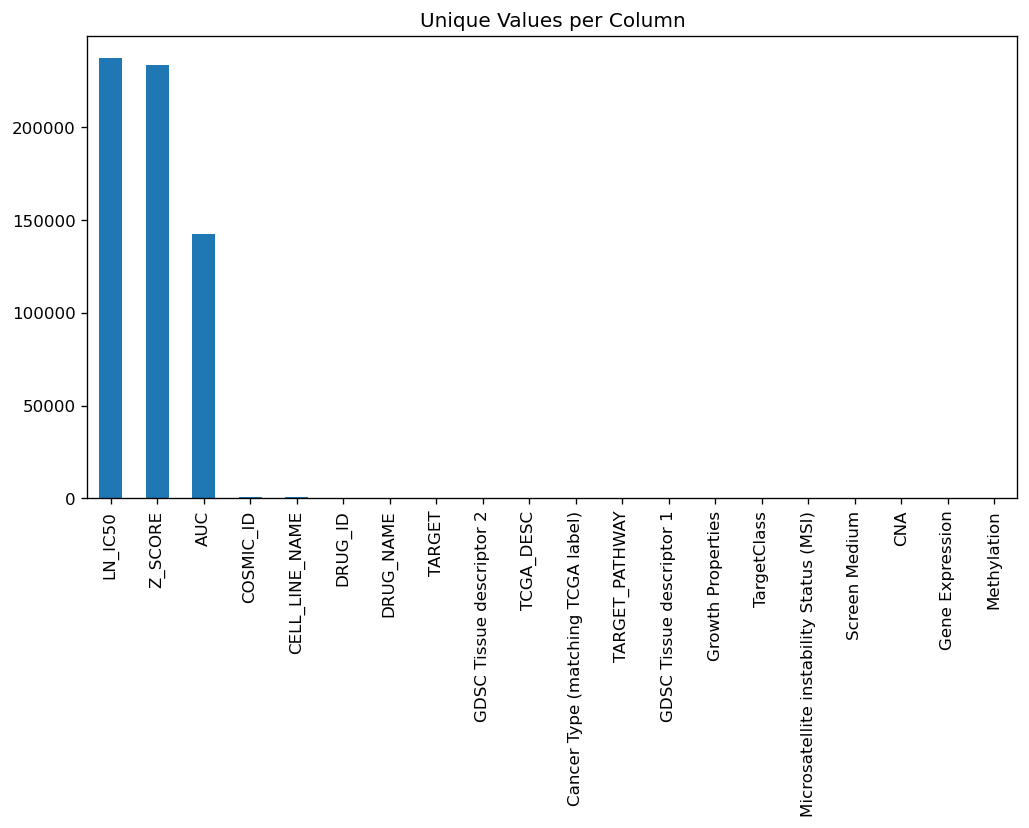

In [16]:
# Show number of unique values for each column
unique_counts = df.nunique().sort_values(ascending=False)
print("Number of unique values per column:")
print(unique_counts)

unique_counts.plot(kind="bar", figsize=(10,5), title="Unique Values per Column")

LN_IC50	IC50 (µM)	Biological meaning	Interpretation
Negative (< 0)	IC50 < 1 µM	The drug achieves 50% inhibition at a small concentration.	Very potent drug effect — cell line is highly sensitive.
Zero (0)	IC50 = 1 µM	Moderate potency — requires 1 µM for 50% inhibition.	Average sensitivity.
Positive (> 0)	IC50 > 1 µM	Needs higher concentration for inhibition.	Resistant or less sensitive to the drug.


Top 20 drugs by Very potent COUNT:
 DRUG_NAME
Dactinomycin            1632
Docetaxel               1432
Bortezomib               953
Staurosporine            948
Sepantronium bromide     941
MG-132                   935
Paclitaxel               911
SN-38                    904
Rapamycin                889
Vinorelbine              861
Dinaciclib               832
Camptothecin             831
Luminespib               828
Dactolisib               819
Romidepsin               717
Epirubicin               708
Vinblastine              686
Eg5_9814                 664
BI-2536                  630
CDK9_5038                618
dtype: int64


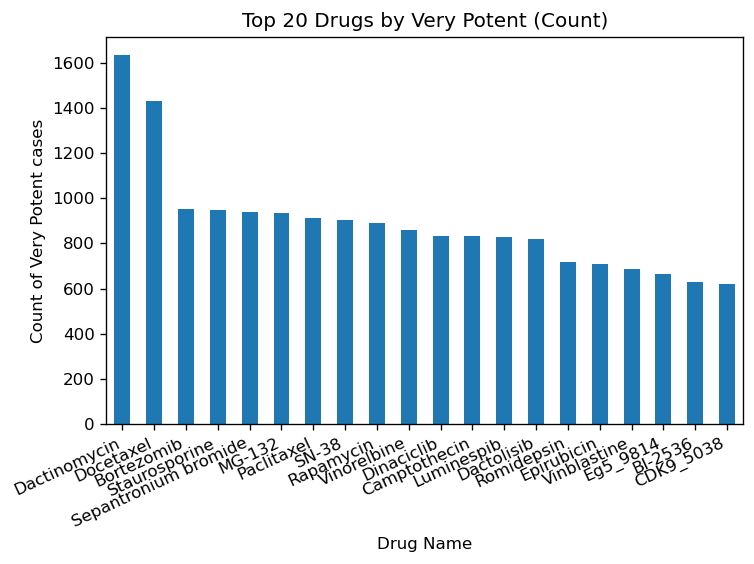

Top 5 drugs by Very Potent COUNT:
 DRUG_NAME
Dactinomycin            1632
Docetaxel               1432
Bortezomib               953
Staurosporine            948
Sepantronium bromide     941
Name: count, dtype: int64


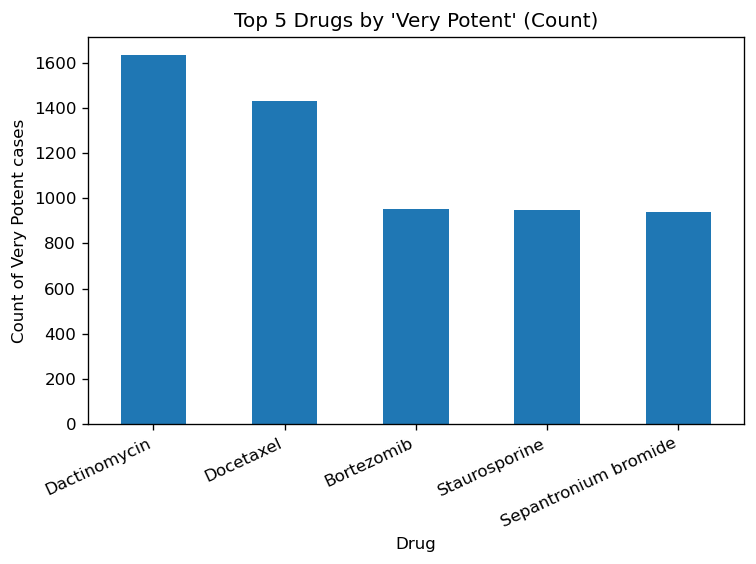

In [17]:
# Top 5 by COUNT of Very potent
counts = (df[df["TargetClass"]=="Very potent"]
          .groupby("DRUG_NAME", dropna=False)
          .size()
          .sort_values(ascending=False)
          .head(20))
print("\nTop 20 drugs by Very potent COUNT:\n", counts)

counts.plot(kind="bar")
plt.title("Top 20 Drugs by Very Potent (Count)")
plt.ylabel("Count of Very Potent cases")
plt.xlabel("Drug Name")
plt.xticks(rotation=25, ha="right")
plt.tight_layout()
plt.show()

if "DRUG_NAME" in df.columns:
    top5_count = (df[df["TargetClass"]=="Very potent"]["DRUG_NAME"]
                  .value_counts()
                  .head(5))
    print("Top 5 drugs by Very Potent COUNT:\n", top5_count)

    ax = top5_count.plot(kind="bar")
    ax.set_title("Top 5 Drugs by 'Very Potent' (Count)")
    ax.set_xlabel("Drug")
    ax.set_ylabel("Count of Very Potent cases")
    plt.xticks(rotation=25, ha="right")
    plt.tight_layout()
    plt.show()
else:
    print("DRUG_NAME column not found; skipping top-5 plot.")

# Applying a classification method.

In [20]:
for col in num_feats:
    if X_tr[col].dtype == object: 
        X_tr[col] = X_tr[col].map({'Y': 1, 'N': 0})
        X_te[col] = X_te[col].map({'Y': 1, 'N': 0})


pre = ColumnTransformer([
    ("num", StandardScaler(), num_feats), 
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_feats)
], remainder='passthrough')  

clf = Pipeline([
    ("pre", pre),
    ("clf", LogisticRegression(max_iter=1000, multi_class="ovr"))
])

clf.fit(X_tr, y_tr)
pred = clf.predict(X_te)
proba = clf.predict_proba(X_te)

print(classification_report(y_te, pred, digits=3))

                     precision    recall  f1-score   support

Average sensitivity      0.752     0.382     0.506      9753
          Resistant      0.851     0.974     0.908     29776
        Very potent      0.707     0.763     0.734      6408

           accuracy                          0.819     45937
          macro avg      0.770     0.706     0.716     45937
       weighted avg      0.810     0.819     0.799     45937



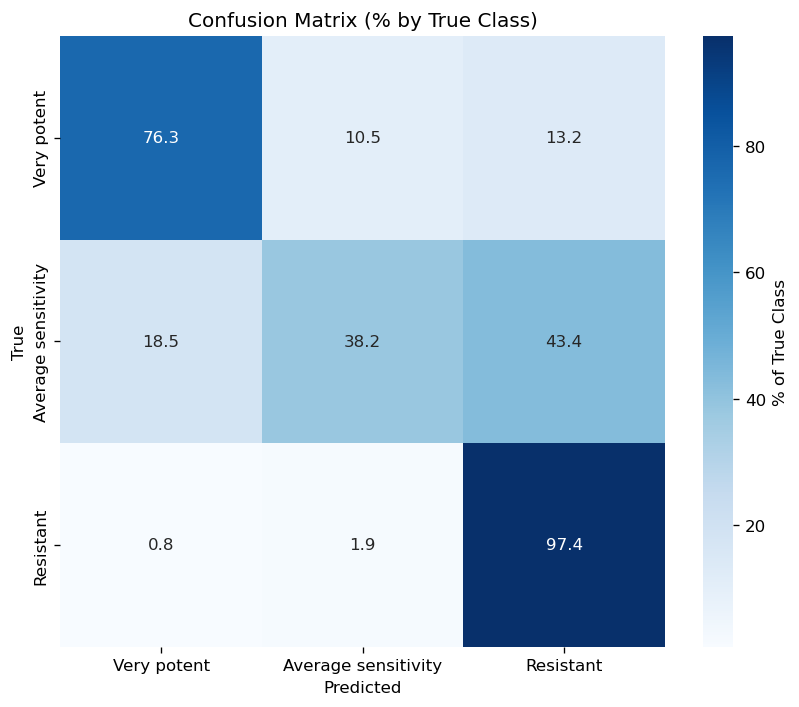

In [22]:
USE_SEABORN = True

labels = ["Very potent","Average sensitivity","Resistant"]
cm = confusion_matrix(y_te, pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

cm_perc = cm_df.div(cm_df.sum(axis=1), axis=0) * 100

if USE_SEABORN:
    plt.figure(figsize=(7,6))
    sns.heatmap(cm_perc, annot=True, fmt=".1f", cmap="Blues",
                xticklabels=labels, yticklabels=labels,
                cbar_kws={'label': '% of True Class'})
    plt.title("Confusion Matrix (% by True Class)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()
else:
    plt.figure(figsize=(7,6))
    plt.imshow(cm_perc.values, cmap="Blues")
    plt.title("Confusion Matrix (% by True Class)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.xticks(range(len(labels)), labels, rotation=20)
    plt.yticks(range(len(labels)), labels)
    
    for (i,j), v in np.ndenumerate(cm_perc.values):
        plt.text(j, i, f"{v:.1f}", ha="center", va="center")
    plt.colorbar(label="% of True Class")
    plt.tight_layout()
    plt.show()

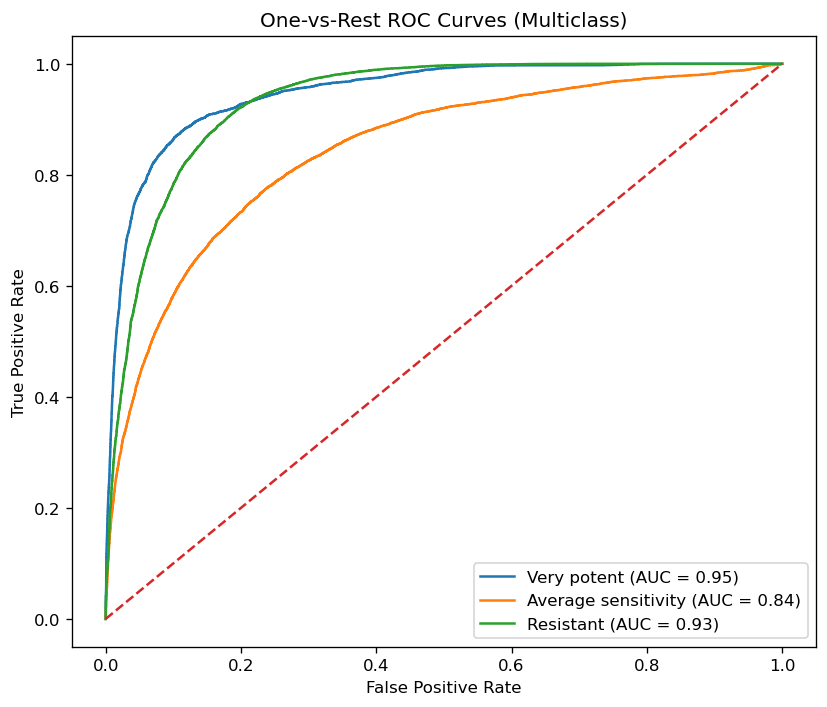

In [24]:
from sklearn.preprocessing import label_binarize

y_true_bin = label_binarize(y_te, classes=labels)


class_order = clf.named_steps["clf"].classes_
class_to_col = {cls: i for i, cls in enumerate(class_order)}

plt.figure(figsize=(7,6))
for cls in labels:
    col = class_to_col.get(cls, None)
    if col is None:
        continue
    fpr, tpr, _ = roc_curve(y_true_bin[:, labels.index(cls)], proba[:, col])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{cls} (AUC = {roc_auc:.2f})")

plt.plot([0,1],[0,1], linestyle="--")
plt.title("One-vs-Rest ROC Curves (Multiclass)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.show()